<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [BHPD2] - Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  A more advanced implementation of the precedent example
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('BHPD2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : BHPD2
Run time             : Wednesday 27 January 2021, 18:22:00
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [2]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

### 2.2 - Option 2 : From a csv file
More fun !

In [3]:
data = pd.read_csv(f'{datasets_dir}/BHPD/origine/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [4]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.53,10.39,11.16,0.08,0.56,6.27,69.21,3.69,9.73,408.19,18.44,357.89,12.71
std,7.98,22.23,6.77,0.27,0.11,0.72,28.32,2.04,8.77,169.72,2.19,89.02,7.18
min,0.01,0.00,0.74,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73
25%,0.09,0.00,5.32,0.00,0.46,5.86,46.52,2.06,4.00,277.00,17.40,375.24,6.80
50%,0.29,0.00,9.69,0.00,0.54,6.21,79.85,3.08,5.00,330.00,18.95,391.60,11.57
75%,3.76,9.38,18.10,0.00,0.63,6.64,94.10,4.81,24.00,666.00,20.20,396.12,16.96
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,21.20,396.90,36.98


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.44,-0.47,-1.54,-0.29,-1.47,-3.74,-2.34,-1.25,-1.00,-1.30,-2.67,-4.02,-1.53
25%,-0.43,-0.47,-0.86,-0.29,-0.85,-0.57,-0.80,-0.80,-0.65,-0.77,-0.48,0.19,-0.82
50%,-0.41,-0.47,-0.22,-0.29,-0.17,-0.09,0.38,-0.30,-0.54,-0.46,0.23,0.38,-0.16
75%,0.03,-0.05,1.03,-0.29,0.63,0.51,0.88,0.54,1.63,1.52,0.81,0.43,0.59
max,10.70,4.03,2.45,3.48,2.74,3.46,1.09,4.13,1.63,1.78,1.26,0.44,3.38


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [6]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5 - Train the model
### 5.1 - Get it

In [7]:
model=get_model_v1( (13,) )

model.summary()
# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [8]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [9]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100


 1/36 [..............................] - ETA: 0s - loss: 650.2097 - mae: 24.3200 - mse: 650.2097

31/36 [========================>.....] - ETA: 0s - loss: 506.4228 - mae: 20.6021 - mse: 506.4228

36/36 [==============================] - 0s 11ms/step - loss: 487.8593 - mae: 20.1665 - mse: 487.8593 - val_loss: 371.3030 - val_mae: 17.1120 - val_mse: 371.3030


Epoch 2/100
 1/36 [..............................] - ETA: 0s - loss: 457.1164 - mae: 19.3226 - mse: 457.1164

32/36 [=========================>....] - ETA: 0s - loss: 272.2232 - mae: 14.5274 - mse: 272.2232

36/36 [==============================] - 0s 3ms/step - loss: 263.9458 - mae: 14.2286 - mse: 263.9458 - val_loss: 153.6606 - val_mae: 10.0381 - val_mse: 153.6606


Epoch 3/100
 1/36 [..............................] - ETA: 0s - loss: 86.4851 - mae: 7.0558 - mse: 86.4851

32/36 [=========================>....] - ETA: 0s - loss: 90.6959 - mae: 7.5660 - mse: 90.6959

36/36 [==============================] - 0s 3ms/step - loss: 92.9459 - mae: 7.5311 - mse: 92.9459 - val_loss: 67.3085 - val_mae: 5.9670 - val_mse: 67.3085


Epoch 4/100
 1/36 [..............................] - ETA: 0s - loss: 31.7458 - mae: 4.7901 - mse: 31.7458

32/36 [=========================>....] - ETA: 0s - loss: 42.9880 - mae: 4.7321 - mse: 42.9880

36/36 [==============================] - 0s 3ms/step - loss: 42.3191 - mae: 4.7278 - mse: 42.3191 - val_loss: 42.5559 - val_mae: 4.6381 - val_mse: 42.5559


Epoch 5/100
 1/36 [..............................] - ETA: 0s - loss: 11.0846 - mae: 2.5174 - mse: 11.0846

32/36 [=========================>....] - ETA: 0s - loss: 31.0288 - mae: 3.9733 - mse: 31.0288

36/36 [==============================] - 0s 3ms/step - loss: 29.2148 - mae: 3.8585 - mse: 29.2148 - val_loss: 33.4394 - val_mae: 4.0292 - val_mse: 33.4394


Epoch 6/100
 1/36 [..............................] - ETA: 0s - loss: 8.9692 - mae: 2.6639 - mse: 8.9692

33/36 [==========================>...] - ETA: 0s - loss: 23.7496 - mae: 3.4442 - mse: 23.7496

36/36 [==============================] - 0s 3ms/step - loss: 24.0123 - mae: 3.4826 - mse: 24.0123 - val_loss: 26.6059 - val_mae: 3.5880 - val_mse: 26.6059


Epoch 7/100
 1/36 [..............................] - ETA: 0s - loss: 75.0032 - mae: 4.4771 - mse: 75.0032

32/36 [=========================>....] - ETA: 0s - loss: 20.6871 - mae: 3.1766 - mse: 20.6871

36/36 [==============================] - 0s 3ms/step - loss: 20.7966 - mae: 3.2107 - mse: 20.7966 - val_loss: 25.0494 - val_mae: 3.4403 - val_mse: 25.0494


Epoch 8/100
 1/36 [..............................] - ETA: 0s - loss: 16.9560 - mae: 2.9498 - mse: 16.9560

32/36 [=========================>....] - ETA: 0s - loss: 19.9091 - mae: 3.0904 - mse: 19.9091

36/36 [==============================] - 0s 3ms/step - loss: 19.3268 - mae: 3.0746 - mse: 19.3268 - val_loss: 22.6187 - val_mae: 3.3072 - val_mse: 22.6187


Epoch 9/100
 1/36 [..............................] - ETA: 0s - loss: 79.2165 - mae: 5.1093 - mse: 79.2165

33/36 [==========================>...] - ETA: 0s - loss: 17.6263 - mae: 2.9114 - mse: 17.6263

36/36 [==============================] - 0s 3ms/step - loss: 17.5231 - mae: 2.9108 - mse: 17.5231 - val_loss: 19.9930 - val_mae: 3.1727 - val_mse: 19.9930


Epoch 10/100
 1/36 [..............................] - ETA: 0s - loss: 18.8025 - mae: 3.6267 - mse: 18.8025

32/36 [=========================>....] - ETA: 0s - loss: 16.7122 - mae: 2.8045 - mse: 16.7122

36/36 [==============================] - 0s 3ms/step - loss: 16.0697 - mae: 2.7698 - mse: 16.0697 - val_loss: 18.9307 - val_mae: 3.1631 - val_mse: 18.9307


Epoch 11/100
 1/36 [..............................] - ETA: 0s - loss: 11.8221 - mae: 2.8684 - mse: 11.8221

33/36 [==========================>...] - ETA: 0s - loss: 15.2447 - mae: 2.6681 - mse: 15.2447

36/36 [==============================] - 0s 3ms/step - loss: 14.9827 - mae: 2.6761 - mse: 14.9827 - val_loss: 18.3378 - val_mae: 3.0912 - val_mse: 18.3378


Epoch 12/100
 1/36 [..............................] - ETA: 0s - loss: 1.6263 - mae: 1.0248 - mse: 1.6263

32/36 [=========================>....] - ETA: 0s - loss: 13.4981 - mae: 2.5773 - mse: 13.4981

36/36 [==============================] - 0s 4ms/step - loss: 14.4603 - mae: 2.6062 - mse: 14.4603 - val_loss: 17.9904 - val_mae: 3.0344 - val_mse: 17.9904


Epoch 13/100
 1/36 [..............................] - ETA: 0s - loss: 6.1783 - mae: 1.9720 - mse: 6.1783

33/36 [==========================>...] - ETA: 0s - loss: 13.9801 - mae: 2.5305 - mse: 13.9801

36/36 [==============================] - 0s 3ms/step - loss: 13.5569 - mae: 2.5030 - mse: 13.5569 - val_loss: 16.9653 - val_mae: 3.0156 - val_mse: 16.9653


Epoch 14/100
 1/36 [..............................] - ETA: 0s - loss: 5.5907 - mae: 1.7901 - mse: 5.5907

32/36 [=========================>....] - ETA: 0s - loss: 12.4185 - mae: 2.4524 - mse: 12.4185

36/36 [==============================] - 0s 3ms/step - loss: 13.2135 - mae: 2.4640 - mse: 13.2135 - val_loss: 16.6383 - val_mae: 2.9509 - val_mse: 16.6383


Epoch 15/100
 1/36 [..............................] - ETA: 0s - loss: 5.5526 - mae: 1.9723 - mse: 5.5526

33/36 [==========================>...] - ETA: 0s - loss: 13.0692 - mae: 2.4392 - mse: 13.0692

36/36 [==============================] - 0s 4ms/step - loss: 12.8308 - mae: 2.4266 - mse: 12.8308 - val_loss: 16.0902 - val_mae: 2.9658 - val_mse: 16.0902


Epoch 16/100
 1/36 [..............................] - ETA: 0s - loss: 5.6606 - mae: 1.8794 - mse: 5.6606

32/36 [=========================>....] - ETA: 0s - loss: 11.8948 - mae: 2.4129 - mse: 11.8948

36/36 [==============================] - 0s 3ms/step - loss: 12.2701 - mae: 2.3987 - mse: 12.2701 - val_loss: 16.2828 - val_mae: 2.9206 - val_mse: 16.2828


Epoch 17/100
 1/36 [..............................] - ETA: 0s - loss: 15.7075 - mae: 3.4142 - mse: 15.7075

32/36 [=========================>....] - ETA: 0s - loss: 11.6606 - mae: 2.3317 - mse: 11.6606

36/36 [==============================] - 0s 3ms/step - loss: 11.9364 - mae: 2.3501 - mse: 11.9364 - val_loss: 16.3826 - val_mae: 2.9105 - val_mse: 16.3826


Epoch 18/100


 1/36 [..............................] - ETA: 0s - loss: 3.7957 - mae: 1.6568 - mse: 3.7957

32/36 [=========================>....] - ETA: 0s - loss: 11.8351 - mae: 2.3723 - mse: 11.8351

36/36 [==============================] - 0s 4ms/step - loss: 11.6662 - mae: 2.3700 - mse: 11.6662 - val_loss: 15.6663 - val_mae: 2.8278 - val_mse: 15.6663


Epoch 19/100
 1/36 [..............................] - ETA: 0s - loss: 11.2464 - mae: 2.8432 - mse: 11.2464

32/36 [=========================>....] - ETA: 0s - loss: 12.0824 - mae: 2.3821 - mse: 12.0824

36/36 [==============================] - 1s 20ms/step - loss: 11.3430 - mae: 2.3113 - mse: 11.3430 - val_loss: 14.8180 - val_mae: 2.7661 - val_mse: 14.8180


Epoch 20/100
 1/36 [..............................] - ETA: 0s - loss: 7.1291 - mae: 2.1578 - mse: 7.1291

32/36 [=========================>....] - ETA: 0s - loss: 10.1320 - mae: 2.2219 - mse: 10.1320

36/36 [==============================] - 0s 3ms/step - loss: 11.2473 - mae: 2.2680 - mse: 11.2473 - val_loss: 14.7309 - val_mae: 2.7871 - val_mse: 14.7309


Epoch 21/100
 1/36 [..............................] - ETA: 0s - loss: 1.6492 - mae: 1.0671 - mse: 1.6492

32/36 [=========================>....] - ETA: 0s - loss: 11.5149 - mae: 2.3190 - mse: 11.5149

36/36 [==============================] - 0s 3ms/step - loss: 10.9338 - mae: 2.2621 - mse: 10.9338 - val_loss: 15.1076 - val_mae: 2.7590 - val_mse: 15.1076


Epoch 22/100
 1/36 [..............................] - ETA: 0s - loss: 2.2461 - mae: 1.3930 - mse: 2.2461

33/36 [==========================>...] - ETA: 0s - loss: 10.6446 - mae: 2.2257 - mse: 10.6446

36/36 [==============================] - 0s 3ms/step - loss: 10.5842 - mae: 2.2373 - mse: 10.5842 - val_loss: 14.4242 - val_mae: 2.7934 - val_mse: 14.4242


Epoch 23/100
 1/36 [..............................] - ETA: 0s - loss: 3.5432 - mae: 1.5405 - mse: 3.5432

32/36 [=========================>....] - ETA: 0s - loss: 10.9358 - mae: 2.2506 - mse: 10.9358

36/36 [==============================] - 0s 3ms/step - loss: 10.5017 - mae: 2.2176 - mse: 10.5017 - val_loss: 15.5430 - val_mae: 2.8467 - val_mse: 15.5430


Epoch 24/100
 1/36 [..............................] - ETA: 0s - loss: 9.1264 - mae: 2.0383 - mse: 9.1264

32/36 [=========================>....] - ETA: 0s - loss: 10.2289 - mae: 2.1826 - mse: 10.2289

36/36 [==============================] - 0s 3ms/step - loss: 10.2317 - mae: 2.1974 - mse: 10.2317 - val_loss: 13.6854 - val_mae: 2.6584 - val_mse: 13.6854


Epoch 25/100
 1/36 [..............................] - ETA: 0s - loss: 12.2879 - mae: 2.6405 - mse: 12.2879

32/36 [=========================>....] - ETA: 0s - loss: 10.3714 - mae: 2.1971 - mse: 10.3714

36/36 [==============================] - 0s 3ms/step - loss: 10.1377 - mae: 2.1815 - mse: 10.1377 - val_loss: 13.5194 - val_mae: 2.5896 - val_mse: 13.5194


Epoch 26/100
 1/36 [..............................] - ETA: 0s - loss: 2.5982 - mae: 1.2959 - mse: 2.5982

33/36 [==========================>...] - ETA: 0s - loss: 10.1730 - mae: 2.1751 - mse: 10.1730

36/36 [==============================] - 0s 3ms/step - loss: 9.8901 - mae: 2.1627 - mse: 9.8901 - val_loss: 14.0073 - val_mae: 2.7238 - val_mse: 14.0073


Epoch 27/100
 1/36 [..............................] - ETA: 0s - loss: 5.2337 - mae: 1.6694 - mse: 5.2337

32/36 [=========================>....] - ETA: 0s - loss: 9.8083 - mae: 2.1338 - mse: 9.8083

36/36 [==============================] - 0s 3ms/step - loss: 9.6460 - mae: 2.1477 - mse: 9.6460 - val_loss: 13.0115 - val_mae: 2.5437 - val_mse: 13.0115


Epoch 28/100
 1/36 [..............................] - ETA: 0s - loss: 5.1569 - mae: 1.7751 - mse: 5.1569

33/36 [==========================>...] - ETA: 0s - loss: 10.0029 - mae: 2.1663 - mse: 10.0029

36/36 [==============================] - 0s 3ms/step - loss: 9.5482 - mae: 2.1272 - mse: 9.5482 - val_loss: 13.3540 - val_mae: 2.6001 - val_mse: 13.3540


Epoch 29/100
 1/36 [..............................] - ETA: 0s - loss: 3.2065 - mae: 1.3825 - mse: 3.2065

33/36 [==========================>...] - ETA: 0s - loss: 9.6787 - mae: 2.1394 - mse: 9.6787

36/36 [==============================] - 0s 3ms/step - loss: 9.2975 - mae: 2.1065 - mse: 9.2975 - val_loss: 12.6968 - val_mae: 2.4941 - val_mse: 12.6968


Epoch 30/100
 1/36 [..............................] - ETA: 0s - loss: 6.6045 - mae: 1.9971 - mse: 6.6045

33/36 [==========================>...] - ETA: 0s - loss: 9.7500 - mae: 2.1194 - mse: 9.7500

36/36 [==============================] - 0s 3ms/step - loss: 9.4078 - mae: 2.0914 - mse: 9.4078 - val_loss: 13.9425 - val_mae: 2.7077 - val_mse: 13.9425


Epoch 31/100
 1/36 [..............................] - ETA: 0s - loss: 9.1990 - mae: 2.2580 - mse: 9.1990

33/36 [==========================>...] - ETA: 0s - loss: 9.3310 - mae: 2.1094 - mse: 9.3310

36/36 [==============================] - 0s 3ms/step - loss: 9.0858 - mae: 2.0797 - mse: 9.0858 - val_loss: 13.3827 - val_mae: 2.6040 - val_mse: 13.3827


Epoch 32/100


 1/36 [..............................] - ETA: 0s - loss: 7.5661 - mae: 2.1296 - mse: 7.5661

32/36 [=========================>....] - ETA: 0s - loss: 8.9988 - mae: 2.0381 - mse: 8.9988

36/36 [==============================] - 0s 3ms/step - loss: 8.8624 - mae: 2.0564 - mse: 8.8624 - val_loss: 12.3937 - val_mae: 2.5310 - val_mse: 12.3937


Epoch 33/100
 1/36 [..............................] - ETA: 0s - loss: 2.6600 - mae: 1.4902 - mse: 2.6600

32/36 [=========================>....] - ETA: 0s - loss: 9.3202 - mae: 2.1069 - mse: 9.3202

36/36 [==============================] - 0s 3ms/step - loss: 9.0567 - mae: 2.0744 - mse: 9.0567 - val_loss: 12.8553 - val_mae: 2.5222 - val_mse: 12.8553


Epoch 34/100
 1/36 [..............................] - ETA: 0s - loss: 0.5771 - mae: 0.6443 - mse: 0.5771

32/36 [=========================>....] - ETA: 0s - loss: 9.1446 - mae: 2.0690 - mse: 9.1446

36/36 [==============================] - 0s 3ms/step - loss: 8.9192 - mae: 2.0626 - mse: 8.9192 - val_loss: 12.3636 - val_mae: 2.4885 - val_mse: 12.3636


Epoch 35/100
 1/36 [..............................] - ETA: 0s - loss: 3.8682 - mae: 1.5138 - mse: 3.8682

32/36 [=========================>....] - ETA: 0s - loss: 8.2530 - mae: 2.0049 - mse: 8.2530

36/36 [==============================] - 0s 3ms/step - loss: 8.4784 - mae: 1.9996 - mse: 8.4784 - val_loss: 13.3922 - val_mae: 2.6816 - val_mse: 13.3922


Epoch 36/100
 1/36 [..............................] - ETA: 0s - loss: 10.7148 - mae: 2.5947 - mse: 10.7148

33/36 [==========================>...] - ETA: 0s - loss: 8.8086 - mae: 2.0213 - mse: 8.8086  

36/36 [==============================] - 0s 3ms/step - loss: 8.5831 - mae: 2.0028 - mse: 8.5831 - val_loss: 12.6774 - val_mae: 2.5683 - val_mse: 12.6774


Epoch 37/100


 1/36 [..............................] - ETA: 0s - loss: 14.5362 - mae: 2.1308 - mse: 14.5362

33/36 [==========================>...] - ETA: 0s - loss: 8.6049 - mae: 2.0261 - mse: 8.6049  

36/36 [==============================] - 0s 3ms/step - loss: 8.4086 - mae: 2.0197 - mse: 8.4086 - val_loss: 12.8747 - val_mae: 2.5896 - val_mse: 12.8747


Epoch 38/100
 1/36 [..............................] - ETA: 0s - loss: 17.6542 - mae: 2.9731 - mse: 17.6542

33/36 [==========================>...] - ETA: 0s - loss: 8.3633 - mae: 2.0068 - mse: 8.3633  

36/36 [==============================] - 0s 3ms/step - loss: 8.1931 - mae: 1.9861 - mse: 8.1931 - val_loss: 12.7682 - val_mae: 2.5099 - val_mse: 12.7682


Epoch 39/100
 1/36 [..............................] - ETA: 0s - loss: 3.4531 - mae: 1.6127 - mse: 3.4531

32/36 [=========================>....] - ETA: 0s - loss: 8.4591 - mae: 2.0087 - mse: 8.4591

36/36 [==============================] - 0s 3ms/step - loss: 8.2121 - mae: 1.9948 - mse: 8.2121 - val_loss: 12.4147 - val_mae: 2.5262 - val_mse: 12.4147


Epoch 40/100


 1/36 [..............................] - ETA: 0s - loss: 8.0741 - mae: 1.7814 - mse: 8.0741

32/36 [=========================>....] - ETA: 0s - loss: 8.3279 - mae: 2.0018 - mse: 8.3279

36/36 [==============================] - 0s 3ms/step - loss: 7.9583 - mae: 1.9803 - mse: 7.9583 - val_loss: 11.8057 - val_mae: 2.4222 - val_mse: 11.8057


Epoch 41/100
 1/36 [..............................] - ETA: 0s - loss: 31.3173 - mae: 3.1255 - mse: 31.3173

33/36 [==========================>...] - ETA: 0s - loss: 8.2614 - mae: 1.9583 - mse: 8.2614  

36/36 [==============================] - 0s 3ms/step - loss: 8.2316 - mae: 1.9757 - mse: 8.2316 - val_loss: 12.0216 - val_mae: 2.4788 - val_mse: 12.0216


Epoch 42/100
 1/36 [..............................] - ETA: 0s - loss: 3.7600 - mae: 1.6729 - mse: 3.7600

32/36 [=========================>....] - ETA: 0s - loss: 7.8853 - mae: 1.8971 - mse: 7.8853

36/36 [==============================] - 0s 3ms/step - loss: 7.8710 - mae: 1.9310 - mse: 7.8710 - val_loss: 12.4387 - val_mae: 2.5021 - val_mse: 12.4387


Epoch 43/100


 1/36 [..............................] - ETA: 0s - loss: 5.4862 - mae: 1.8600 - mse: 5.4862

33/36 [==========================>...] - ETA: 0s - loss: 8.0002 - mae: 1.9109 - mse: 8.0002

36/36 [==============================] - 0s 3ms/step - loss: 7.8200 - mae: 1.9185 - mse: 7.8200 - val_loss: 12.3099 - val_mae: 2.5199 - val_mse: 12.3099


Epoch 44/100


 1/36 [..............................] - ETA: 0s - loss: 3.8619 - mae: 1.5097 - mse: 3.8619

33/36 [==========================>...] - ETA: 0s - loss: 7.7210 - mae: 1.9051 - mse: 7.7210

36/36 [==============================] - 0s 3ms/step - loss: 7.5973 - mae: 1.8853 - mse: 7.5973 - val_loss: 12.2818 - val_mae: 2.5568 - val_mse: 12.2818


Epoch 45/100


 1/36 [..............................] - ETA: 0s - loss: 3.3374 - mae: 1.1382 - mse: 3.3374

32/36 [=========================>....] - ETA: 0s - loss: 7.8115 - mae: 1.9431 - mse: 7.8115

36/36 [==============================] - 0s 3ms/step - loss: 7.6112 - mae: 1.9331 - mse: 7.6112 - val_loss: 11.5111 - val_mae: 2.4086 - val_mse: 11.5111


Epoch 46/100
 1/36 [..............................] - ETA: 0s - loss: 2.8774 - mae: 1.3325 - mse: 2.8774

32/36 [=========================>....] - ETA: 0s - loss: 7.7251 - mae: 1.9519 - mse: 7.7251

36/36 [==============================] - 0s 3ms/step - loss: 7.3964 - mae: 1.9182 - mse: 7.3964 - val_loss: 12.3020 - val_mae: 2.5405 - val_mse: 12.3020


Epoch 47/100
 1/36 [..............................] - ETA: 0s - loss: 8.7814 - mae: 2.1454 - mse: 8.7814

33/36 [==========================>...] - ETA: 0s - loss: 6.7421 - mae: 1.8489 - mse: 6.7421

36/36 [==============================] - 0s 3ms/step - loss: 7.3249 - mae: 1.8734 - mse: 7.3249 - val_loss: 13.0305 - val_mae: 2.6522 - val_mse: 13.0305


Epoch 48/100
 1/36 [..............................] - ETA: 0s - loss: 1.2074 - mae: 0.8920 - mse: 1.2074

33/36 [==========================>...] - ETA: 0s - loss: 6.8343 - mae: 1.8771 - mse: 6.8343

36/36 [==============================] - 0s 3ms/step - loss: 7.2513 - mae: 1.8983 - mse: 7.2513 - val_loss: 12.7707 - val_mae: 2.5369 - val_mse: 12.7707


Epoch 49/100
 1/36 [..............................] - ETA: 0s - loss: 4.0472 - mae: 1.6528 - mse: 4.0472

33/36 [==========================>...] - ETA: 0s - loss: 7.0413 - mae: 1.8414 - mse: 7.0413

36/36 [==============================] - 0s 3ms/step - loss: 7.1052 - mae: 1.8561 - mse: 7.1052 - val_loss: 12.0984 - val_mae: 2.4790 - val_mse: 12.0984


Epoch 50/100


 1/36 [..............................] - ETA: 0s - loss: 3.3742 - mae: 1.3778 - mse: 3.3742

32/36 [=========================>....] - ETA: 0s - loss: 7.4176 - mae: 1.8562 - mse: 7.4176

36/36 [==============================] - 0s 3ms/step - loss: 7.0675 - mae: 1.8403 - mse: 7.0675 - val_loss: 12.2812 - val_mae: 2.5808 - val_mse: 12.2812


Epoch 51/100


 1/36 [..............................] - ETA: 0s - loss: 5.1731 - mae: 1.8483 - mse: 5.1731

33/36 [==========================>...] - ETA: 0s - loss: 7.0443 - mae: 1.8167 - mse: 7.0443

36/36 [==============================] - 0s 3ms/step - loss: 6.9827 - mae: 1.8372 - mse: 6.9827 - val_loss: 13.0278 - val_mae: 2.5878 - val_mse: 13.0278


Epoch 52/100


 1/36 [..............................] - ETA: 0s - loss: 1.5954 - mae: 1.0496 - mse: 1.5954

32/36 [=========================>....] - ETA: 0s - loss: 6.2871 - mae: 1.8068 - mse: 6.2871

36/36 [==============================] - 0s 3ms/step - loss: 7.1321 - mae: 1.8383 - mse: 7.1321 - val_loss: 11.9308 - val_mae: 2.5689 - val_mse: 11.9308


Epoch 53/100


 1/36 [..............................] - ETA: 0s - loss: 4.6129 - mae: 1.7187 - mse: 4.6129

33/36 [==========================>...] - ETA: 0s - loss: 7.0010 - mae: 1.8325 - mse: 7.0010

36/36 [==============================] - 0s 3ms/step - loss: 6.8513 - mae: 1.8121 - mse: 6.8513 - val_loss: 12.3439 - val_mae: 2.4748 - val_mse: 12.3439


Epoch 54/100


 1/36 [..............................] - ETA: 0s - loss: 3.5751 - mae: 1.5125 - mse: 3.5751

33/36 [==========================>...] - ETA: 0s - loss: 7.0961 - mae: 1.8370 - mse: 7.0961

36/36 [==============================] - 0s 3ms/step - loss: 6.8257 - mae: 1.8074 - mse: 6.8257 - val_loss: 13.1049 - val_mae: 2.7329 - val_mse: 13.1049


Epoch 55/100


 1/36 [..............................] - ETA: 0s - loss: 4.1861 - mae: 1.5949 - mse: 4.1861

33/36 [==========================>...] - ETA: 0s - loss: 6.7908 - mae: 1.8251 - mse: 6.7908

36/36 [==============================] - 0s 3ms/step - loss: 6.7042 - mae: 1.8203 - mse: 6.7042 - val_loss: 11.3388 - val_mae: 2.3720 - val_mse: 11.3388


Epoch 56/100
 1/36 [..............................] - ETA: 0s - loss: 8.3143 - mae: 2.6264 - mse: 8.3143

33/36 [==========================>...] - ETA: 0s - loss: 6.5862 - mae: 1.8199 - mse: 6.5862

36/36 [==============================] - 0s 3ms/step - loss: 6.7872 - mae: 1.8252 - mse: 6.7872 - val_loss: 11.9651 - val_mae: 2.5540 - val_mse: 11.9651


Epoch 57/100
 1/36 [..............................] - ETA: 0s - loss: 2.4972 - mae: 1.3958 - mse: 2.4972

33/36 [==========================>...] - ETA: 0s - loss: 6.5551 - mae: 1.7886 - mse: 6.5551

36/36 [==============================] - 0s 3ms/step - loss: 6.4978 - mae: 1.7850 - mse: 6.4978 - val_loss: 11.2586 - val_mae: 2.4161 - val_mse: 11.2586


Epoch 58/100
 1/36 [..............................] - ETA: 0s - loss: 4.7226 - mae: 1.8762 - mse: 4.7226

32/36 [=========================>....] - ETA: 0s - loss: 6.3957 - mae: 1.7815 - mse: 6.3957

36/36 [==============================] - 0s 3ms/step - loss: 6.4010 - mae: 1.7627 - mse: 6.4010 - val_loss: 11.7428 - val_mae: 2.4010 - val_mse: 11.7428


Epoch 59/100
 1/36 [..............................] - ETA: 0s - loss: 1.9786 - mae: 1.0273 - mse: 1.9786

33/36 [==========================>...] - ETA: 0s - loss: 6.4023 - mae: 1.7496 - mse: 6.4023

36/36 [==============================] - 0s 3ms/step - loss: 6.4722 - mae: 1.7676 - mse: 6.4722 - val_loss: 11.7174 - val_mae: 2.5212 - val_mse: 11.7174


Epoch 60/100


 1/36 [..............................] - ETA: 0s - loss: 8.6044 - mae: 2.3831 - mse: 8.6044

32/36 [=========================>....] - ETA: 0s - loss: 6.4757 - mae: 1.7994 - mse: 6.4757

36/36 [==============================] - 0s 3ms/step - loss: 6.1854 - mae: 1.7711 - mse: 6.1854 - val_loss: 11.6870 - val_mae: 2.4226 - val_mse: 11.6870


Epoch 61/100


 1/36 [..............................] - ETA: 0s - loss: 12.0178 - mae: 2.3819 - mse: 12.0178

32/36 [=========================>....] - ETA: 0s - loss: 6.5799 - mae: 1.7930 - mse: 6.5799  

36/36 [==============================] - 0s 3ms/step - loss: 6.2941 - mae: 1.7753 - mse: 6.2941 - val_loss: 11.6667 - val_mae: 2.4761 - val_mse: 11.6667


Epoch 62/100


 1/36 [..............................] - ETA: 0s - loss: 6.9510 - mae: 1.8016 - mse: 6.9510

32/36 [=========================>....] - ETA: 0s - loss: 5.9816 - mae: 1.7457 - mse: 5.9816

36/36 [==============================] - 0s 3ms/step - loss: 6.0772 - mae: 1.7589 - mse: 6.0772 - val_loss: 12.1629 - val_mae: 2.6408 - val_mse: 12.1629


Epoch 63/100


 1/36 [..............................] - ETA: 0s - loss: 2.6114 - mae: 1.2515 - mse: 2.6114

32/36 [=========================>....] - ETA: 0s - loss: 5.9435 - mae: 1.7174 - mse: 5.9435

36/36 [==============================] - 0s 3ms/step - loss: 6.1771 - mae: 1.7418 - mse: 6.1771 - val_loss: 12.3861 - val_mae: 2.4496 - val_mse: 12.3861


Epoch 64/100


 1/36 [..............................] - ETA: 0s - loss: 2.3628 - mae: 0.9805 - mse: 2.3628

32/36 [=========================>....] - ETA: 0s - loss: 6.2883 - mae: 1.7498 - mse: 6.2883

36/36 [==============================] - 0s 3ms/step - loss: 6.1258 - mae: 1.7396 - mse: 6.1258 - val_loss: 11.3048 - val_mae: 2.4540 - val_mse: 11.3048


Epoch 65/100


 1/36 [..............................] - ETA: 0s - loss: 13.5293 - mae: 2.8158 - mse: 13.5293

32/36 [=========================>....] - ETA: 0s - loss: 6.1709 - mae: 1.7641 - mse: 6.1709  

36/36 [==============================] - 0s 3ms/step - loss: 5.9367 - mae: 1.7461 - mse: 5.9367 - val_loss: 11.9743 - val_mae: 2.4947 - val_mse: 11.9743


Epoch 66/100


 1/36 [..............................] - ETA: 0s - loss: 7.3550 - mae: 2.4893 - mse: 7.3550

33/36 [==========================>...] - ETA: 0s - loss: 5.9550 - mae: 1.6928 - mse: 5.9550

36/36 [==============================] - 1s 29ms/step - loss: 5.9206 - mae: 1.6829 - mse: 5.9206 - val_loss: 11.1031 - val_mae: 2.3541 - val_mse: 11.1031


Epoch 67/100
 1/36 [..............................] - ETA: 0s - loss: 3.6156 - mae: 1.4245 - mse: 3.6156

33/36 [==========================>...] - ETA: 0s - loss: 5.9119 - mae: 1.6807 - mse: 5.9119

36/36 [==============================] - 0s 3ms/step - loss: 5.7106 - mae: 1.6617 - mse: 5.7106 - val_loss: 11.2678 - val_mae: 2.4766 - val_mse: 11.2678


Epoch 68/100
 1/36 [..............................] - ETA: 0s - loss: 1.7926 - mae: 1.1787 - mse: 1.7926

32/36 [=========================>....] - ETA: 0s - loss: 6.0087 - mae: 1.7495 - mse: 6.0087

36/36 [==============================] - 0s 3ms/step - loss: 5.7699 - mae: 1.7177 - mse: 5.7699 - val_loss: 12.0539 - val_mae: 2.4515 - val_mse: 12.0539


Epoch 69/100


 1/36 [..............................] - ETA: 0s - loss: 4.4837 - mae: 1.6533 - mse: 4.4837

33/36 [==========================>...] - ETA: 0s - loss: 5.9718 - mae: 1.7056 - mse: 5.9718

36/36 [==============================] - 0s 3ms/step - loss: 5.9233 - mae: 1.7023 - mse: 5.9233 - val_loss: 11.4292 - val_mae: 2.3618 - val_mse: 11.4292


Epoch 70/100


 1/36 [..............................] - ETA: 0s - loss: 3.7952 - mae: 1.3921 - mse: 3.7952

33/36 [==========================>...] - ETA: 0s - loss: 5.6720 - mae: 1.6487 - mse: 5.6720

36/36 [==============================] - 0s 3ms/step - loss: 5.7177 - mae: 1.6654 - mse: 5.7177 - val_loss: 11.9285 - val_mae: 2.5545 - val_mse: 11.9285


Epoch 71/100


 1/36 [..............................] - ETA: 0s - loss: 2.9527 - mae: 1.3413 - mse: 2.9527

33/36 [==========================>...] - ETA: 0s - loss: 5.6087 - mae: 1.6713 - mse: 5.6087

36/36 [==============================] - 0s 3ms/step - loss: 5.6906 - mae: 1.6961 - mse: 5.6906 - val_loss: 11.5343 - val_mae: 2.4631 - val_mse: 11.5343


Epoch 72/100


 1/36 [..............................] - ETA: 0s - loss: 3.0792 - mae: 1.5354 - mse: 3.0792

33/36 [==========================>...] - ETA: 0s - loss: 5.7745 - mae: 1.7188 - mse: 5.7745

36/36 [==============================] - 0s 3ms/step - loss: 5.5993 - mae: 1.6961 - mse: 5.5993 - val_loss: 11.2920 - val_mae: 2.4229 - val_mse: 11.2920


Epoch 73/100


 1/36 [..............................] - ETA: 0s - loss: 2.8064 - mae: 1.5012 - mse: 2.8064

33/36 [==========================>...] - ETA: 0s - loss: 5.2601 - mae: 1.6244 - mse: 5.2601

36/36 [==============================] - 0s 3ms/step - loss: 5.5948 - mae: 1.6596 - mse: 5.5948 - val_loss: 11.2798 - val_mae: 2.3567 - val_mse: 11.2798


Epoch 74/100


 1/36 [..............................] - ETA: 0s - loss: 4.7736 - mae: 1.8047 - mse: 4.7736

32/36 [=========================>....] - ETA: 0s - loss: 5.4904 - mae: 1.6649 - mse: 5.4904

36/36 [==============================] - 0s 3ms/step - loss: 5.3196 - mae: 1.6426 - mse: 5.3196 - val_loss: 11.6957 - val_mae: 2.4471 - val_mse: 11.6957


Epoch 75/100


 1/36 [..............................] - ETA: 0s - loss: 5.2588 - mae: 1.8478 - mse: 5.2588

32/36 [=========================>....] - ETA: 0s - loss: 5.5334 - mae: 1.6370 - mse: 5.5334

36/36 [==============================] - 0s 3ms/step - loss: 5.3766 - mae: 1.6243 - mse: 5.3766 - val_loss: 11.5355 - val_mae: 2.3920 - val_mse: 11.5355


Epoch 76/100
 1/36 [..............................] - ETA: 0s - loss: 7.5533 - mae: 1.9012 - mse: 7.5533

33/36 [==========================>...] - ETA: 0s - loss: 4.9337 - mae: 1.6329 - mse: 4.9337

36/36 [==============================] - 0s 3ms/step - loss: 5.2362 - mae: 1.6352 - mse: 5.2362 - val_loss: 11.4039 - val_mae: 2.4964 - val_mse: 11.4039


Epoch 77/100
 1/36 [..............................] - ETA: 0s - loss: 1.0806 - mae: 0.8339 - mse: 1.0806

33/36 [==========================>...] - ETA: 0s - loss: 4.8676 - mae: 1.6063 - mse: 4.8676

36/36 [==============================] - 0s 3ms/step - loss: 5.2376 - mae: 1.6263 - mse: 5.2376 - val_loss: 11.8549 - val_mae: 2.4969 - val_mse: 11.8549


Epoch 78/100


 1/36 [..............................] - ETA: 0s - loss: 9.4634 - mae: 2.0229 - mse: 9.4634

32/36 [=========================>....] - ETA: 0s - loss: 5.1181 - mae: 1.6055 - mse: 5.1181

36/36 [==============================] - 0s 3ms/step - loss: 5.1819 - mae: 1.6288 - mse: 5.1819 - val_loss: 11.7870 - val_mae: 2.3981 - val_mse: 11.7870


Epoch 79/100


 1/36 [..............................] - ETA: 0s - loss: 1.5940 - mae: 1.0928 - mse: 1.5940

33/36 [==========================>...] - ETA: 0s - loss: 5.0333 - mae: 1.6234 - mse: 5.0333

36/36 [==============================] - 0s 3ms/step - loss: 5.0892 - mae: 1.6294 - mse: 5.0892 - val_loss: 12.7118 - val_mae: 2.5767 - val_mse: 12.7118


Epoch 80/100


 1/36 [..............................] - ETA: 0s - loss: 3.4898 - mae: 1.5605 - mse: 3.4898

33/36 [==========================>...] - ETA: 0s - loss: 5.2644 - mae: 1.6166 - mse: 5.2644

36/36 [==============================] - 0s 3ms/step - loss: 5.1583 - mae: 1.6053 - mse: 5.1583 - val_loss: 11.8039 - val_mae: 2.6096 - val_mse: 11.8039


Epoch 81/100


 1/36 [..............................] - ETA: 0s - loss: 0.8906 - mae: 0.8719 - mse: 0.8906

33/36 [==========================>...] - ETA: 0s - loss: 5.0859 - mae: 1.6121 - mse: 5.0859

36/36 [==============================] - 0s 3ms/step - loss: 4.9142 - mae: 1.5954 - mse: 4.9142 - val_loss: 11.3268 - val_mae: 2.3985 - val_mse: 11.3268


Epoch 82/100


 1/36 [..............................] - ETA: 0s - loss: 9.1581 - mae: 2.2572 - mse: 9.1581

33/36 [==========================>...] - ETA: 0s - loss: 5.0437 - mae: 1.5912 - mse: 5.0437

36/36 [==============================] - 0s 3ms/step - loss: 4.9506 - mae: 1.5801 - mse: 4.9506 - val_loss: 11.8619 - val_mae: 2.5834 - val_mse: 11.8619


Epoch 83/100


 1/36 [..............................] - ETA: 0s - loss: 3.9159 - mae: 1.4021 - mse: 3.9159

33/36 [==========================>...] - ETA: 0s - loss: 4.1786 - mae: 1.4989 - mse: 4.1786

36/36 [==============================] - 0s 3ms/step - loss: 4.9417 - mae: 1.5804 - mse: 4.9417 - val_loss: 11.1878 - val_mae: 2.3971 - val_mse: 11.1878


Epoch 84/100


 1/36 [..............................] - ETA: 0s - loss: 2.5088 - mae: 1.2673 - mse: 2.5088

32/36 [=========================>....] - ETA: 0s - loss: 4.5587 - mae: 1.5536 - mse: 4.5587

36/36 [==============================] - 0s 3ms/step - loss: 4.8439 - mae: 1.5945 - mse: 4.8439 - val_loss: 11.6722 - val_mae: 2.4008 - val_mse: 11.6722


Epoch 85/100


 1/36 [..............................] - ETA: 0s - loss: 4.1257 - mae: 1.5823 - mse: 4.1257

32/36 [=========================>....] - ETA: 0s - loss: 4.7007 - mae: 1.5596 - mse: 4.7007

36/36 [==============================] - 0s 3ms/step - loss: 4.8113 - mae: 1.5677 - mse: 4.8113 - val_loss: 11.9304 - val_mae: 2.6288 - val_mse: 11.9304


Epoch 86/100
 1/36 [..............................] - ETA: 0s - loss: 8.0586 - mae: 2.1236 - mse: 8.0586

32/36 [=========================>....] - ETA: 0s - loss: 4.9996 - mae: 1.5886 - mse: 4.9996

36/36 [==============================] - 0s 3ms/step - loss: 4.8617 - mae: 1.5715 - mse: 4.8617 - val_loss: 11.9765 - val_mae: 2.6131 - val_mse: 11.9765


Epoch 87/100
 1/36 [..............................] - ETA: 0s - loss: 2.8540 - mae: 1.3150 - mse: 2.8540

32/36 [=========================>....] - ETA: 0s - loss: 4.7804 - mae: 1.5920 - mse: 4.7804

36/36 [==============================] - 0s 3ms/step - loss: 4.7269 - mae: 1.5744 - mse: 4.7269 - val_loss: 11.9900 - val_mae: 2.6228 - val_mse: 11.9900


Epoch 88/100
 1/36 [..............................] - ETA: 0s - loss: 2.4792 - mae: 1.3943 - mse: 2.4792

32/36 [=========================>....] - ETA: 0s - loss: 4.5467 - mae: 1.5376 - mse: 4.5467

36/36 [==============================] - 0s 3ms/step - loss: 4.6709 - mae: 1.5721 - mse: 4.6709 - val_loss: 11.8313 - val_mae: 2.5355 - val_mse: 11.8313


Epoch 89/100


 1/36 [..............................] - ETA: 0s - loss: 9.6483 - mae: 1.6983 - mse: 9.6483

33/36 [==========================>...] - ETA: 0s - loss: 4.7766 - mae: 1.5765 - mse: 4.7766

36/36 [==============================] - 0s 3ms/step - loss: 4.6797 - mae: 1.5636 - mse: 4.6797 - val_loss: 11.8266 - val_mae: 2.5640 - val_mse: 11.8266


Epoch 90/100


 1/36 [..............................] - ETA: 0s - loss: 1.3943 - mae: 0.8290 - mse: 1.3943

32/36 [=========================>....] - ETA: 0s - loss: 4.1007 - mae: 1.4680 - mse: 4.1007

36/36 [==============================] - 0s 3ms/step - loss: 4.4073 - mae: 1.5103 - mse: 4.4073 - val_loss: 11.6360 - val_mae: 2.4195 - val_mse: 11.6360


Epoch 91/100


 1/36 [..............................] - ETA: 0s - loss: 1.5895 - mae: 1.0610 - mse: 1.5895

32/36 [=========================>....] - ETA: 0s - loss: 4.6368 - mae: 1.5296 - mse: 4.6368

36/36 [==============================] - 0s 3ms/step - loss: 4.5640 - mae: 1.5282 - mse: 4.5640 - val_loss: 11.9516 - val_mae: 2.5785 - val_mse: 11.9516


Epoch 92/100


 1/36 [..............................] - ETA: 0s - loss: 1.5976 - mae: 0.9752 - mse: 1.5976

33/36 [==========================>...] - ETA: 0s - loss: 4.5216 - mae: 1.5076 - mse: 4.5216

36/36 [==============================] - 0s 3ms/step - loss: 4.4171 - mae: 1.4967 - mse: 4.4171 - val_loss: 12.1904 - val_mae: 2.6263 - val_mse: 12.1904


Epoch 93/100


 1/36 [..............................] - ETA: 0s - loss: 10.8327 - mae: 2.3746 - mse: 10.8327

32/36 [=========================>....] - ETA: 0s - loss: 4.4801 - mae: 1.5107 - mse: 4.4801  

36/36 [==============================] - 0s 3ms/step - loss: 4.4917 - mae: 1.5110 - mse: 4.4917 - val_loss: 11.3583 - val_mae: 2.4011 - val_mse: 11.3583


Epoch 94/100


 1/36 [..............................] - ETA: 0s - loss: 1.4155 - mae: 1.0347 - mse: 1.4155

32/36 [=========================>....] - ETA: 0s - loss: 4.1689 - mae: 1.5125 - mse: 4.1689

36/36 [==============================] - 0s 3ms/step - loss: 4.5507 - mae: 1.5432 - mse: 4.5507 - val_loss: 12.3900 - val_mae: 2.5726 - val_mse: 12.3900


Epoch 95/100
 1/36 [..............................] - ETA: 0s - loss: 2.4724 - mae: 1.2359 - mse: 2.4724

32/36 [=========================>....] - ETA: 0s - loss: 4.4180 - mae: 1.5038 - mse: 4.4180

36/36 [==============================] - 0s 3ms/step - loss: 4.4011 - mae: 1.4981 - mse: 4.4011 - val_loss: 11.6696 - val_mae: 2.4253 - val_mse: 11.6696


Epoch 96/100
 1/36 [..............................] - ETA: 0s - loss: 6.5995 - mae: 1.7948 - mse: 6.5995

32/36 [=========================>....] - ETA: 0s - loss: 4.4036 - mae: 1.5442 - mse: 4.4036

36/36 [==============================] - 0s 3ms/step - loss: 4.3621 - mae: 1.5377 - mse: 4.3621 - val_loss: 12.7482 - val_mae: 2.6269 - val_mse: 12.7482


Epoch 97/100
 1/36 [..............................] - ETA: 0s - loss: 2.5466 - mae: 1.2685 - mse: 2.5466

33/36 [==========================>...] - ETA: 0s - loss: 4.3934 - mae: 1.4755 - mse: 4.3934

36/36 [==============================] - 0s 3ms/step - loss: 4.2535 - mae: 1.4572 - mse: 4.2535 - val_loss: 11.5211 - val_mae: 2.4002 - val_mse: 11.5211


Epoch 98/100
 1/36 [..............................] - ETA: 0s - loss: 10.6758 - mae: 2.6701 - mse: 10.6758

32/36 [=========================>....] - ETA: 0s - loss: 4.2060 - mae: 1.4969 - mse: 4.2060  

36/36 [==============================] - 0s 3ms/step - loss: 4.2153 - mae: 1.5013 - mse: 4.2153 - val_loss: 11.4737 - val_mae: 2.4473 - val_mse: 11.4737


Epoch 99/100


 1/36 [..............................] - ETA: 0s - loss: 2.4467 - mae: 1.2066 - mse: 2.4467

33/36 [==========================>...] - ETA: 0s - loss: 4.3942 - mae: 1.5074 - mse: 4.3942

36/36 [==============================] - 0s 3ms/step - loss: 4.3093 - mae: 1.4973 - mse: 4.3093 - val_loss: 11.9330 - val_mae: 2.5679 - val_mse: 11.9330


Epoch 100/100


 1/36 [..............................] - ETA: 0s - loss: 3.6569 - mae: 1.4386 - mse: 3.6569

33/36 [==========================>...] - ETA: 0s - loss: 4.5221 - mae: 1.5279 - mse: 4.5221

36/36 [==============================] - 0s 3ms/step - loss: 4.2961 - mae: 1.4869 - mse: 4.2961 - val_loss: 12.6521 - val_mae: 2.6723 - val_mse: 12.6521


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 12.6521
x_test / mae       : 2.6723
x_test / mse       : 12.6521


### 6.2 - Training history
What was the best result during our training ?

In [11]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.3541


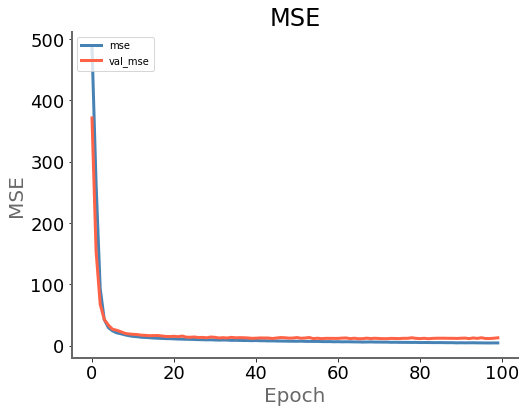

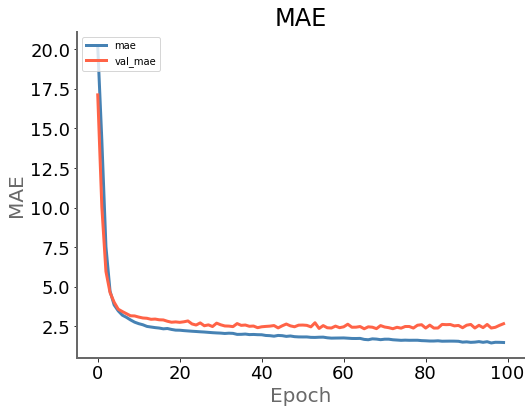

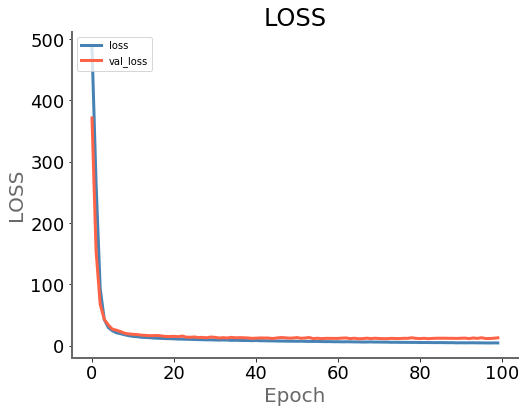

In [12]:
pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [13]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 11.1031
x_test / mae       : 2.3541
x_test / mse       : 11.1031


### 7.3 - Make a prediction

In [15]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [16]:
predictions = loaded_model.predict( my_data )
print("Prediction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], real_price))

Prediction : 10.11 K$   Reality : 10.40 K$


In [17]:
pwk.end()

End time is : Wednesday 27 January 2021, 18:22:17
Duration is : 00:00:18 826ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>